   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (USB Audio Device ), MME (2 in, 0 out)
   2 Stereo-mix (Realtek(R) Audio), MME (2 in, 0 out)
   3 Microphone Array (Realtek(R) Au, MME (2 in, 0 out)
   4 Microphone (Camo), MME (2 in, 0 out)
   5 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  6 Speaker/Headphone (Realtek(R) A, MME (0 in, 2 out)
   7 Speakers (USB Audio Device ), MME (0 in, 2 out)
   8 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   9 Microphone (USB Audio Device ), Windows DirectSound (2 in, 0 out)
  10 Stereo-mix (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  11 Microphone Array (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  12 Microphone (Camo), Windows DirectSound (2 in, 0 out)
  13 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  14 Speaker/Headphone (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
  15 Speakers (USB Audio Device ), Windows DirectSound (0 in, 2 out)
  16 ASIO4ALL v2, ASIO

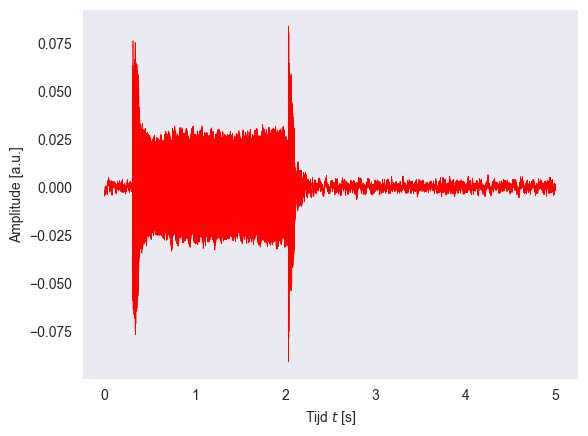

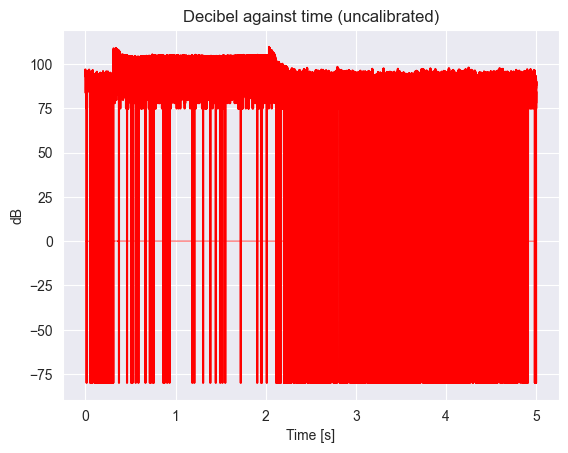

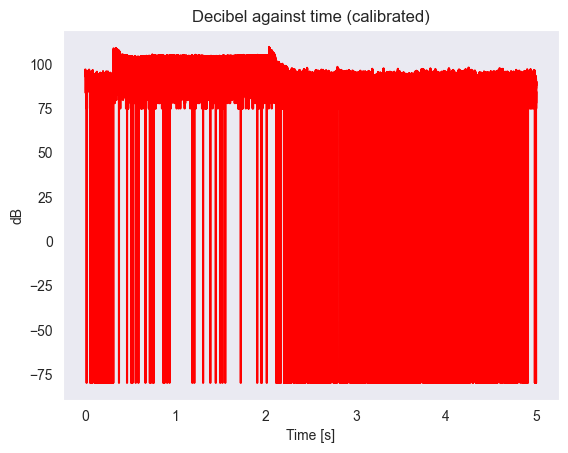

avg:49.72367534807685


In [238]:
# RECORD SOUND CELL

import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np

# Set to True if you want to debug values
debug = False

# Debugs list of (sound) devices with their id. Use this to retrieve the ID of the microphone you want to use
def debug_sound_devices():
    print(sd.query_devices())

# Will generate a tone & record it at the same time. Then it will stop the tone and keep recording to capture the reverb time.
def record(_tone_duration, extra_duration):
    # sampling frequency
    fs = 44100

    # Generate a 700 Hz sine wave tone
    tone_samples = _tone_duration * fs
    freq = 700
    time_array = np.arange(tone_samples) / fs
    tone = np.sin(2 * np.pi * freq * time_array)

    # Set the volume of the tone (100%)
    volume = 1

    # Start playing the sin wave tone and recording audio simultaneously
    indata = sd.playrec(volume * tone, samplerate=fs, channels=1)

    # Wait for the sound to finish playing
    sd.wait()

    # Continue recording for an additional X seconds
    extra_samples = extra_duration * fs
    extra_data = sd.rec(extra_samples, samplerate=fs, channels=1)
    sd.wait()

    _sound_stop_index = indata[:,0].size - 1

    # Concatenate the recorded audio data
    recording = np.concatenate((indata, extra_data))[:,0]
    _duration = _tone_duration + extra_duration
    return recording, _duration, _sound_stop_index, fs

# Plot amplitude / intensity of microphone against time
def plot_amplitude_against_time(_duration, _fs, _values, _time_stamps):
    plt.figure(dpi=100)
    plt.plot(_time_stamps, _values, 'r-', ms=0.5, lw=0.5)
    plt.grid()
    plt.xlabel(r"Tijd $t$ [s]")
    # arbitrary units (we hebben nog niets gekalibreerd)
    plt.ylabel(r"Amplitude [a.u.]")

# Convert (absolute) intensity to decibels
def calculate_decibels(_intensity_array):
    i_0 = 1e-12
    i = (_intensity_array + 1e-20)
    return 10 * np.log10(i / i_0)

# Calibrate decibels with calibration results (see 'Kalibratie rapport')
def calibrate_decibels(_decibel_array, _decibel_coefficient, _decibel_offset):
    return (_decibel_array - _decibel_offset) / _decibel_coefficient

def plot_decibel_against_time(_time_stamps, _decibel_array, _title):
    plt.plot(_time_stamps, _decibel_array, 'r-')
    plt.grid()
    plt.xlabel("Time [s]")
    plt.ylabel("dB")
    plt.title(_title)
    plt.show()

if debug:
    debug_sound_devices()

# --- Step 1 record ---
values, total_duration, sound_stop_index, sample_rate = record(2, 3)
# Create time stamps for plotting
time_stamps = np.linspace(0, total_duration, int(sample_rate*total_duration))

# Debug amplitude / intensity of microphone against time
if debug:
    plot_amplitude_against_time(_duration=total_duration, _fs=sample_rate, _values=values, _time_stamps=time_stamps)

# --- Step 2: Convert to absolute values ---
absolute_values = np.absolute(values)

# Debug absolute amplitude / intensity of microphone against time
if debug:
    plot_amplitude_against_time(_duration=total_duration, _fs=sample_rate, _values=absolute_values, _time_stamps=time_stamps)

# --- Step 3: Convert to absolute intensity to decibel values ---
decibel_array = calculate_decibels(_intensity_array=absolute_values)

# Debug plot decibel values
if debug:
    plot_decibel_against_time(_time_stamps=time_stamps, _decibel_array=decibel_array, _title="Decibel against time (uncalibrated)")

# --- Step 4: Calibrate decibel values ---
calibrated_decibel_array = calibrate_decibels(_decibel_array=decibel_array, _decibel_coefficient=0.4756, _decibel_offset=69.59)

# Debug plot calibrated decibel values
if debug:
    plot_decibel_against_time(_time_stamps=time_stamps, _decibel_array=decibel_array, _title="Decibel against time (calibrated)")

avg:49.72367534807685
Decay time start: 2.128671785359571


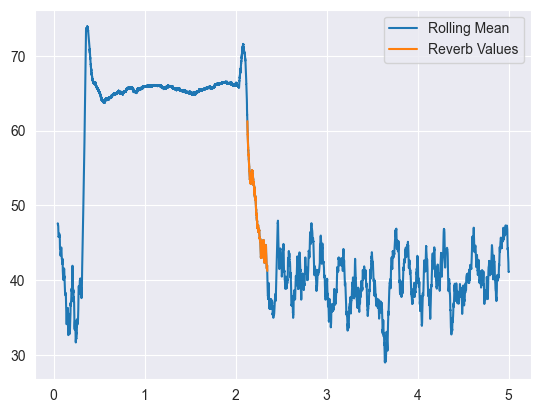

Nagalm tijd: 
0.6571458373960883


In [239]:
import pandas as pd

# Calculate reverb time from timestamps, dB array & index when sound stops
def get_reverb_time(_time_stamps, _sound_stop_index, _decibel_array):
    # Find sound level before drop
    sound_level_before_drop = _decibel_array[_sound_stop_index]
    # Find first 5 dB drop since 'sound_level_before_drop', this is the starting threshold
    _decay_start_point_index = np.argmax((_decibel_array <= sound_level_before_drop - 5) & (_time_stamps > _time_stamps[_sound_stop_index]))
    sound_level_decay_start = _decibel_array[_decay_start_point_index]

    # Find the index of the first data point where the sound level is 20 dB below the starting threshold
    _decay_stop_point_index = np.argmax((_decibel_array <= sound_level_decay_start - 20) & (_time_stamps > _time_stamps[_decay_start_point_index]))

    # Calculate the time it takes for the sound level to decay by 60 dB
    _reverb_time = (_time_stamps[_decay_stop_point_index] - _time_stamps[_decay_start_point_index]) * 3

    return _reverb_time, _decay_start_point_index, _decay_stop_point_index

# DataFrame time against calibrated decibels
df = pd.DataFrame({'Time': time_stamps, 'Decibels': calibrated_decibel_array})

# Take the average of the decibels so that the plot line varies less
rolling_mean = df['Decibels'].rolling(window=2000).mean()

# DataFrame of time against averaged decibels
df = pd.DataFrame({'Time': time_stamps, 'Rolling Mean': rolling_mean})

# plot the original data and the rolling mean
plt.plot(df['Time'], rolling_mean, label='Rolling Mean')

reverb_time, decay_start_point_index, decay_stop_point_index = get_reverb_time(_time_stamps=df['Time'], _decibel_array=rolling_mean, _sound_stop_index=sound_stop_index)

# Select the rows in the DataFrame that fall within the reverb time range
time_range_data = df.loc[(df['Time'].index >= decay_start_point_index) & (df['Time'].index <= decay_stop_point_index)]

# Extract the time and decibel values into separate arrays
time_range_times = time_range_data['Time'].values
time_range_decibels = time_range_data['Rolling Mean'].values

# Plot reverb time is same plot
plt.plot(time_range_times, time_range_decibels, label='Reverb Values')
plt.legend()

plt.show()

print("Nagalm tijd: ")
print(str(reverb_time))

In [240]:
import os
import numpy as np
# Open file if exists, otherwise create it
if os.path.exists('nagalmtijden.csv'):
    df = pd.read_csv('nagalmtijden.csv')
else:
    df = pd.DataFrame({'punten': [], 'nagalmtijd': []})

# Set the value of 'punten' to which point you are currently recording
df = df.append({'punten': 20, 'nagalmtijd': reverb_time}, ignore_index=True)

df.to_csv('nagalmtijden.csv', index=False)

# Debug all measurements
print(df)

    Punten  nagalmtijd
0      1.0    0.297688
1      1.0    0.255307
2      1.0    0.223538
3      2.0    0.202178
4      2.0    0.340614
5      2.0    0.319593
6      3.0    0.331090
7      3.0    0.329321
8      3.0    0.321430
9      4.0    0.095034
10     4.0    0.105375
11     4.0    0.099728
12     5.0    0.098232
13     5.0    0.091497
14     5.0    0.085034
15     6.0    0.327825
16     6.0    0.316328
17     6.0    0.316600
18     7.0    0.306192
19     7.0    0.092245
20     7.0    0.087483
21     8.0    0.104218
22     8.0    0.101633
23     8.0    0.137416
24     9.0    0.182654
25     9.0    0.235171
26     9.0    0.279049
27    10.0    0.260681
28    10.0    0.248368
29    10.0    0.363199
30    11.0    0.304355
31    11.0    0.394832
32    11.0    0.380274
33    12.0    0.380138
34    12.0    0.338777
35    12.0    0.332791
36    13.0    0.300410
37    13.0    0.232722
38    13.0    0.214967
39    14.0    0.122518
40    14.0    0.294219
41    14.0    0.255375
42    15.0 

C:\Users\Jaimy\AppData\Local\Temp\ipykernel_28592\3679117641.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Punten': 20, 'nagalmtijd': reverb_time}, ignore_index=True)
